In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def plotsample(data, Y=None, plot_scale=None, view=[30,-60], title=None, 
               show=True, save=False, filepath=None, label_mapping=None):
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(projection='3d', proj_type = 'ortho')

    if plot_scale is not None:
        ax.set_box_aspect(plot_scale)
    else:
        ax.set_box_aspect([np.ptp(data[:, 0]), np.ptp(data[:, 1]), np.ptp(data[:, 2])])
    
    if Y is not None:
        scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=Y, s=5)
        legends = np.unique(Y)
    else:
        scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], s=5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(*view)
    if title is not None:
        plt.title(title)
    
    if label_mapping is not None:
        handles = [plt.Line2D([0], [0], marker='o', color='w', label=label_mapping[label], 
                    markerfacecolor=plt.cm.viridis(label / max(Y)), markersize=10) 
                    for label in np.unique(Y)]
        ax.legend(handles=handles)
    
    if save:
        if filepath is None:
            filepath = 'sample.png'
        plt.savefig(filepath)

    if show:
        plt.show()
    else:
        plt.close()

In [3]:
num_p = 150
bg_size = 20
bg_std_depth=0.05
bg_std_xy=0.02

In [4]:
# points = np.zeros((num_p ** 2, 2))
# for i in range(num_p):
#     for j in range(num_p):
#         points[i * num_p + j, 0] = -bg_size / 1.5 + 2 * bg_size / 1.5 / num_p * i
#         points[i * num_p + j, 1] = -bg_size + 2 * bg_size / num_p * j

# xyz = np.zeros((num_p ** 2, 3))
# xyz[:, 0:2] = points
# z = -0.023* (xyz[:, 1]) ** 2 
# xyz[:, 2] = z
# xyz[xyz[:,1] > 0, 2] = 0

# plotsample(xyz, None, show=True, view=[0, 180])

### Normal Sample Generation

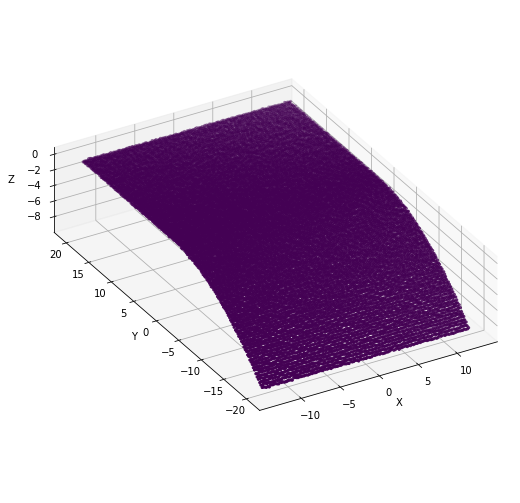

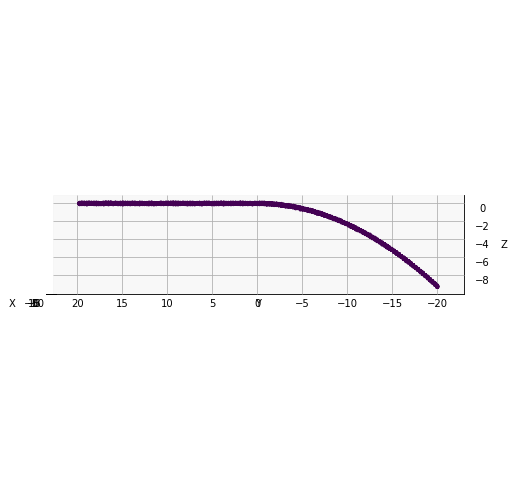

In [5]:
pts = []
labels = []
delta_zs = []
for i in range(num_p):
    for j in range(num_p):
        coo_x = -bg_size / 1.5 + 2 * bg_size / 1.5 / num_p * i
        coo_y = -bg_size + 2 * bg_size / num_p * j
        coo_z = -0.023 * coo_y ** 2 if coo_y < 0 else 0
        delta_z = np.random.normal(scale=bg_std_depth)
        point = np.array(
            [[coo_x + np.random.normal(scale=bg_std_xy)], [coo_y + np.random.normal(scale=bg_std_xy)],
             [coo_z + delta_z]])
        label = 0
        surface = 0
        pts.append(point) # (n,3,1)
        labels.append(label)
        delta_zs.append(delta_z)
xyz = np.array(pts)
labels = np.array(labels)

plotsample(xyz, labels, show=True, view=[30, -120])
plotsample(xyz, labels, show=True, view=[0, 180])

### Defective Sample Generation

In [6]:
defect_pos=[[0], [-10]]
defect_depth=3
defect_radius=2.4
defect_trans=1.4
step=-0.35

depth_trans = 0.5 * defect_depth
transition_depth = -defect_depth

In the original code, for points which r1 < dist < r2, an artificial delta_z is posed (see NOTE below), where the algorithm is basically: (k is the ratio)
```
step + k**2/2 * transition_depth
```
The code is not clear, and, **transition_depth** is not **depth_trans** based on the definiton above. 

The delta_z for such points make more sense by:
```
step + k**2 * depth_trans
```


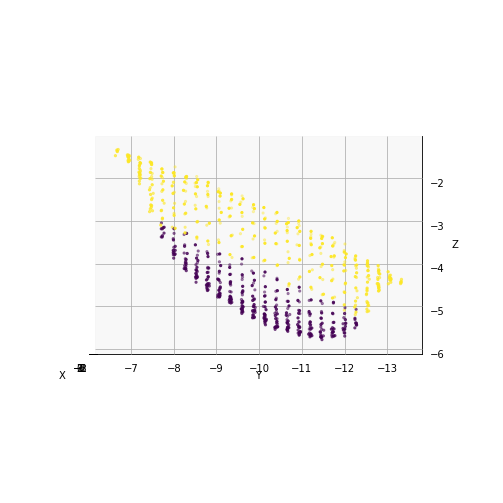

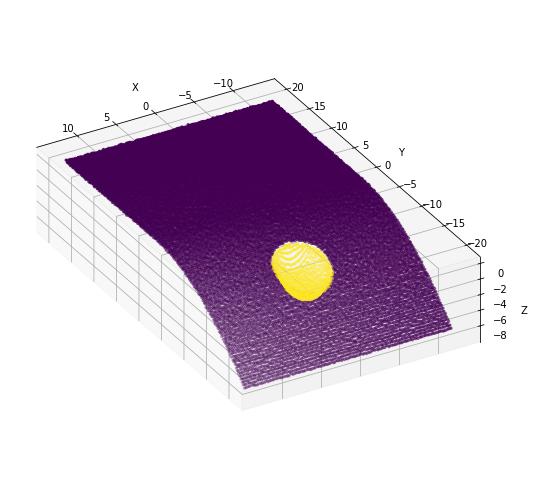

In [7]:

pts = []
labels = []
surface_index = []
delta_zs = []
for i in range(num_p):
    for j in range(num_p):
        coo_x = -bg_size / 1.5 + 2 * bg_size / 1.5 / num_p * i
        coo_y = -bg_size + 2 * bg_size / num_p * j
        coo_z = -0.023 * coo_y ** 2 if coo_y < 0 else 0
        coo = np.array([[coo_x], [coo_y]], np.float64)
        dist = np.linalg.norm(coo - defect_pos, axis=0) 
        min_dist = np.min(dist)

        delta_z = np.random.normal(scale=bg_std_depth)
        point = np.array(
            [[coo_x + np.random.normal(scale=bg_std_xy)], [coo_y + np.random.normal(scale=bg_std_xy)],
             [coo_z + delta_z]])
        label = 0
        surface = 0
        if dist >= defect_radius * defect_trans:
            pass
        elif dist < defect_radius:
            point += np.array([[0], [0], [-depth_trans - (defect_depth - depth_trans) * (np.sqrt(defect_radius ** 2 - min_dist ** 2)) / defect_radius]])
            label = 1
            surface = 1
        else:
            rt = defect_radius * defect_trans
            degree = 0.0
            k = (rt - min_dist) / (rt - defect_radius) * (1 - degree) + degree
            # NOTE: artifical delta_z 
            art_delta_z = step + k * (defect_trans * defect_radius - min_dist) / ((2 * defect_trans - 2) * defect_radius) * transition_depth
            # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            # It's same as: step + k**2/2 * transition_depth
            # print(np.abs(art_delta_z - step - k**2/2 * transition_depth) < 1e-3)
            point += np.array([[0], [0], [art_delta_z]])
            
            label = 1
            surface = 2
        pts.append(point)
        labels.append(label)
        surface_index.append(surface)
        delta_zs.append(delta_z)
labels = np.array(labels)
xyz = np.array(pts)
surface_index = np.array(surface_index)

plotsample(xyz[labels==1], surface_index[labels==1], show=True, view=[0, 180])
plotsample(xyz, labels, show=True, view=[-30, 120])

### Updated Code

In [8]:
from PCD_Sample_Gen import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


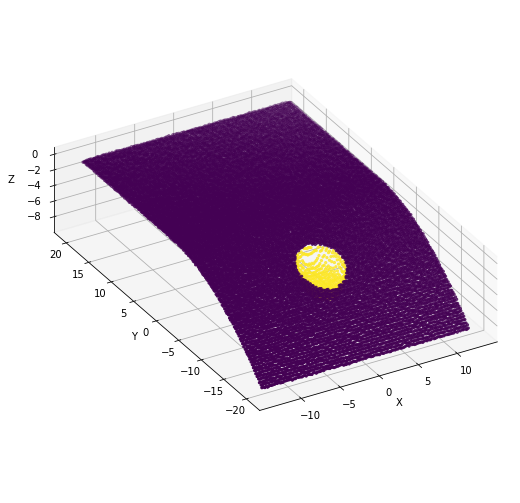

In [9]:
xyz, labels, surface_index, delta_zs = generate_normal_surface(z_func=curvy_z)
# plotsample(xyz, labels, show=True)
# # generate defect
sample_xyz, sample_labels, sample_suface = generate_defect_on_surface(xyz, labels, surface_index,
                                                                        defect_pos=[0, -10], move_via_normal=False)
plotsample(sample_xyz, sample_labels, show=True)